<a href="https://colab.research.google.com/github/fxsipudx/Basic-Word-Tokenization-with-NLTK/blob/main/Monitoring_Particle_Size_in_Battery_Materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

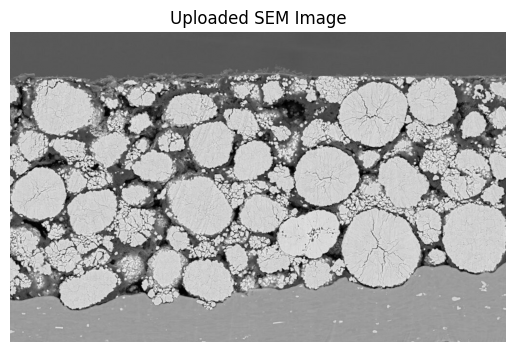

   ID  Area  Perimeter  Eccentricity  Convexity
0   1  13.5  15.071068      0.815751   0.931034
1   2   9.5  13.071068      0.840602   0.904762
2   3   1.5   5.414214      0.000000   1.000000
3   4  58.5  37.213203      0.698336   0.785235
4   5   9.5  12.242641      0.714878   0.950000
Total particles found: 200
Mean Area: 2289.0725
Standard Deviation: 26162.779394863905


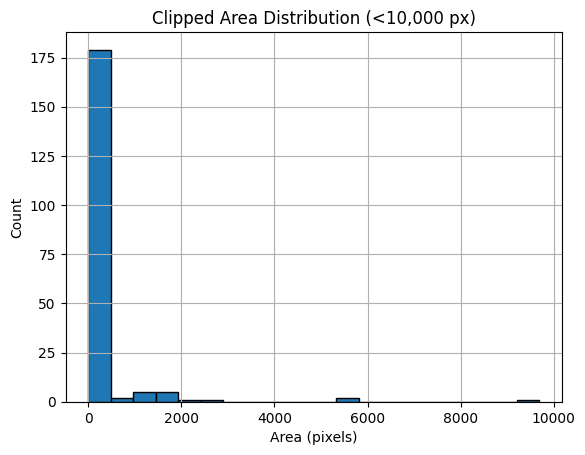

Clipped Mean: 242.7219387755102
Clipped Std Dev: 969.8804435854743


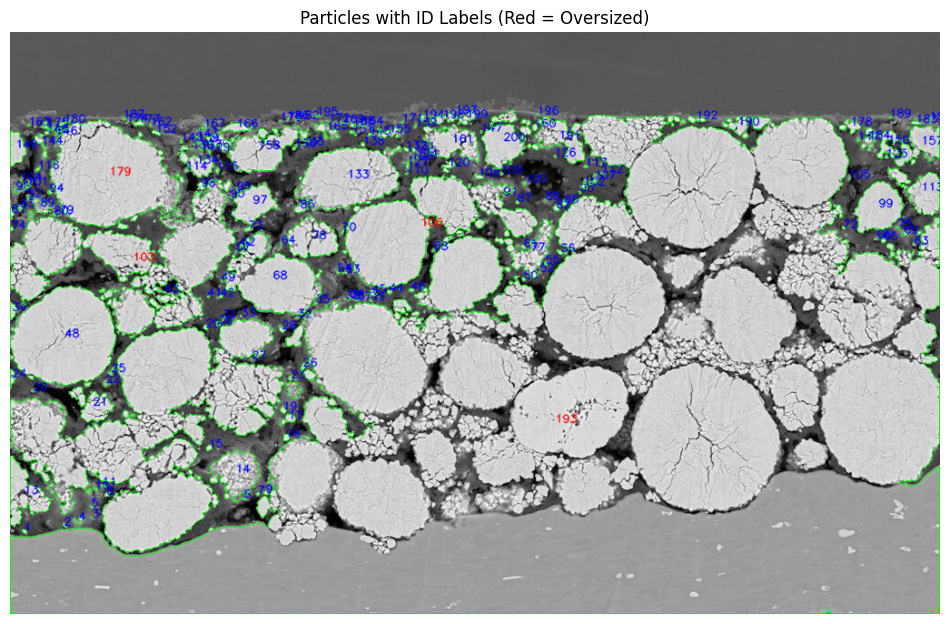

In [46]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

def analyze_particles(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    thresh_val = threshold_otsu(blurred)
    binary = blurred > thresh_val
    binary_uint8 = binary.astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for idx, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, closed=True)
        if len(cnt) >= 5:
            (x, y), (Ma, ma), angle = cv2.fitEllipse(cnt)
            eccentricity = np.sqrt(1 - (Ma / ma) ** 2) if ma != 0 else 0
        else:
            eccentricity = 0

        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        convexity = area / hull_area if hull_area != 0 else 0

        features.append({
            "ID": idx + 1,
            "Area": area,
            "Perimeter": perimeter,
            "Eccentricity": eccentricity,
            "Convexity": convexity
        })

    df = pd.DataFrame(features)
    return df, contours  # Return both!

# Load and display image
img_path = "/content/images1.jpeg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Uploaded SEM Image")
plt.axis('off')
plt.show()

# Analyze particles
df, contours = analyze_particles(img)
print(df.head())
print(f"Total particles found: {len(df)}")



print("Mean Area:", df["Area"].mean())
print("Standard Deviation:", df["Area"].std())

# Clip and replot
filtered = df[df["Area"] < 10000]
plt.hist(filtered["Area"], bins=20, edgecolor='black')
plt.title("Clipped Area Distribution (<10,000 px)")
plt.xlabel("Area (pixels)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("Clipped Mean:", filtered["Area"].mean())
print("Clipped Std Dev:", filtered["Area"].std())

# Drawing function
def draw_particles_with_ids(img, contours, df, area_threshold=None):
    img_copy = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    for idx, cnt in enumerate(contours):
        cv2.drawContours(img_copy, [cnt], -1, (0, 255, 0), 1)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            particle_area = df.loc[idx, "Area"]
            color = (0, 0, 255) if area_threshold and particle_area > area_threshold else (255, 0, 0)
            cv2.putText(img_copy, str(idx + 1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)
    return img_copy

# Draw and show
area_threshold = 10000
labeled_img = draw_particles_with_ids(img, contours, df, area_threshold)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
plt.title("Particles with ID Labels (Red = Oversized)")
plt.axis('off')
plt.show()